<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 4
<br>
<b>Deadline:</b> May 05, 2021 (Wednesday) 23:00
</div>

# Exercise 9.2. Generative adversarial networks (GANs). WGAN-GP: Wasserstein GAN with gradient penalty

The goal of this exercise is to get familiar with WGAN-GP: one of the most popular versions of GANs, which is relatively easy to train.

The algorithm was introduced in the paper [Improved Training of Wasserstein GANs](https://arxiv.org/pdf/1704.00028.pdf).

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as transforms
import torchvision.utils as utils

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [5]:
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data

We will use MNIST data in this exercise. Note that we re-scale images so that the pixel intensities are in the range [-1, 1].

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Scale to [-1, 1]
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Wasserstein GAN (WGAN)

The WGAN value function is constructed as
$$
  \min_G \max_{D \in \mathcal{D}} E_{x∼P_r}[D(x)] − E_{\tilde x∼P_g}[D(\tilde x)]
$$
where
* the dicriminator $D$ is constrained to be from the set $\mathcal{D}$ of 1-Lipschitz functions
* $P_r$ is the data distribution
* $P_g$ is the model distribution. Samples from the model distribution are produced as follows:
\begin{align}
z &\sim N(0, I)
\\
\tilde x &= G(z)
\end{align}

## Generator

Implement the generator in the cell below. We recommend you to use the same architecture of the generator as in Exercise 11.1.

In [8]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        """WGAN generator.
        
        Args:
          nz:  Number of elements in the latent code.
          ngf: Base size (number of channels) of the generator layers.
          nc:  Number of channels in the generated images.
        """
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.generator = nn.Sequential(
                            nn.ConvTranspose2d(nz, 4*ngf, 4, stride=2, bias=False),
                            nn.BatchNorm2d(4*ngf),
                            nn.ReLU(True),
                            nn.ConvTranspose2d(4*ngf, 2*ngf, 4, stride=2, bias=False),
                            nn.BatchNorm2d(2*ngf),
                            nn.ReLU(True),                          
                            nn.ConvTranspose2d(2*ngf, ngf, 4, stride=1, bias=False),
                            nn.BatchNorm2d(ngf),
                            nn.ReLU(True),
                            nn.ConvTranspose2d(ngf, nc, 4, stride=2, bias=False),
                            nn.Tanh(),
                        )
        

    def forward(self, z, verbose=False):
        """Generate images by transforming the given noise tensor.
        
        Args:
          z of shape (batch_size, nz, 1, 1): Tensor of noise samples. We use the last two singleton dimensions
              so that we can feed z to the generator without reshaping.
          verbose (bool): Whether to print intermediate shapes (True) or not (False).
        
        Returns:
          out of shape (batch_size, nc, 28, 28): Generated images.
        """
        # YOUR CODE HERE
        # raise NotImplementedError()
        out = self.generator(z)
        return out

In [9]:
def test_Generator_shapes():
    batch_size = 32
    nz = 10
    netG = Generator(nz, ngf=64, nc=1)

    noise = torch.randn(batch_size, nz, 1, 1)
    out = netG(noise, verbose=True)

    assert out.shape == torch.Size([batch_size, 1, 28, 28]), f"Bad out.shape: {out.shape}"
    print('Success')

test_Generator_shapes()

Success


### Loss for training the generator

The generator is trained to minimize the relevant part of the value function using a fixed discriminator $D$:
$$
  \min_G − E_{\tilde{x} \sim P_g}[D( \tilde x)]
$$

In [10]:
def generator_loss(netD, fake_images):
    """Loss computed to train the WGAN generator.

    Args:
      netD: The discriminator whose forward function takes inputs of shape (batch_size, nc, 28, 28)
         and produces outputs of shape (batch_size, 1).
      fake_images of shape (batch_size, nc, 28, 28): Fake images produces by the generator.

    Returns:
      loss: The relevant part of the WGAN value function.
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    output = netD(fake_images)
   
    loss = -torch.mean(output)
   # loss = output.mean()
    
    return loss
    

In [11]:
# This cell tests generator_loss()

## Discriminator

Implement the WGAN discriminator in the cell below. You can use almost the same architecture as the architecture of the discriminator in Exercise 11.1. The difference is that there is no need to use `sigmoid` nonlinearity in the output layer because the output of the discriminator does not have to be between 0 and 1.

In [12]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        super(Discriminator, self).__init__()
        """
        Args:
          nc:  Number of channels in the images.
          ndf: Base size (number of channels) of the discriminator layers.
        """
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.discriminator = nn.Sequential(
                            nn.Conv2d(nc, ndf, 4, 2, bias=False),
                            nn.LeakyReLU(0.2),
                            nn.Conv2d(ndf, ndf*2, 4, 1, bias=False),
                            nn.LeakyReLU(0.2),
                            nn.Conv2d(ndf*2, ndf*4, 4, 2, bias = False),
                            nn.LeakyReLU(0.2),
                            nn.Conv2d(ndf*4, nc, 4, 2, bias=False),
                            #nn.Sigmoid()
                        )
        

    def forward(self, x, verbose=False):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Images to be evaluated.
        
        Returns:
          out of shape (batch_size,): Discriminator outputs for images x.
        """
        # YOUR CODE HERE
        #raise NotImplementedError()
        
        out = self.discriminator(x).reshape(-1,)
        return out

In [13]:
def test_Discriminator_shapes():
    nz = 10  # size of the latent z vector
    netD = Discriminator(nc=1, ndf=64)

    batch_size = 32
    images = torch.ones(batch_size, 1, 28, 28)
    out = netD(images, verbose=True)
    assert out.shape == torch.Size([batch_size]), f"Bad out.shape: {out.shape}"
    print('Success')

test_Discriminator_shapes()

Success


### Loss for training the WGAN discriminator

Recall the value function of WGAN:
$$
  \min_G \max_{D \in \mathcal{D}} E_{x∼P_r}[D(x)] − E_{\tilde x∼P_g}[D(\tilde x)]
$$
To tune the discriminator, we need to minimize the following function:
$$
  \min_{D \in \mathcal{D}} - E_{x∼P_r}[D(x)] + E_{\tilde x∼P_g}[D(\tilde x)]
$$
You need to implement this loss function *assuming no constraints on D* in the function below.

In [14]:
def discriminator_loss(netD, real_images, fake_images):
    """
    Args:
      netD: The discriminator.
      real_images of shape (batch_size, nc, 28, 28): Real images.
      fake_images of shape (batch_size, nc, 28, 28): Fake images.

    Returns:
      loss (scalar tensor): Loss for training the WGAN discriminator.
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    reals_output = netD(real_images)
    fakes_output = netD(fake_images)
    loss = -torch.mean(reals_output) + torch.mean(fakes_output)
    return loss

In [15]:
# This cell tests discriminator_loss()

Without constraints on $D$, the WGAN value function can be made infinitely large. WGAN constrains the derivative of $D$ using a gradient penalty. The penalty is computed at random points between real images and generated ones using the following procedure:
* Given a real image $x$ and a fake image $\tilde x$, draw a random number $\epsilon \sim U[0,1]$
* $\hat{x} \leftarrow \epsilon x + (1−\epsilon) \tilde x$
* Compute the gradient penalty $(‖\nabla_{\hat{x}} D(\hat{x})‖_2−1)^2$
where $\nabla_{\hat{x}} D(\hat{x})$ is the gradient of $D$ computed at $\hat{x}$.

Your task is to implement the gradient penalty in the cell below.

Notes:

* We need to compute the gradient $\nabla D$ so that we can differentiate through the gradient when computing the derivatives wrt the parameters of the discriminator. This can be achieved by using function [torch.autograd.grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad) which can create a computational graph with the gradient computations.
* The gradient penalty is the average of $(‖\nabla_{\hat{x}} D(\hat{x})‖_2−1)^2$ computed across all samples.
* The second output returned by the function is needed for testing your implementation.

In [16]:
def gradient_penalty(netD, real, fake_detached):
    """
    Args:
      netD: The discriminator.
      real of shape (batch_size, nc, 28, 28): Real images.
      fake_detached of shape (batch_size, nc, 28, 28): Fake images (detached from the computational graph).

    Returns:
      grad_penalty (scalar tensor): Gradient penalty.
      x of shape (batch_size, nc, 28, 28): Points x-hat in which the gradient penalty is computed.
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    n_elements = real.nelement()
    
    batch_size = real.size(0)
    colors = real.size(1)
    image_width = real.size(2)
    image_height = real.size(3)
    
    alpha = torch.rand(batch_size, 1).expand(batch_size, int(n_elements / batch_size)).contiguous()
    alpha = alpha.view(batch_size, colors, image_width, image_height).to(device)

    fake_detached = fake_detached.view(batch_size, colors, image_width, image_height)
    
    interpolates = alpha * real.detach() + ((1 - alpha) * fake_detached)
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)
    
    d_interpolates = netD(interpolates)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones(d_interpolates.size()).to(device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() 
    return gradient_penalty, interpolates

In [17]:
tests.test_gradient_penalty(gradient_penalty)

loss: tensor(729., grad_fn=<MeanBackward0>)
expected: tensor(729.)
Success


# Training WGAN-GP

We will now train WGAN-GP. To assess the quality of the generated samples, we will again use the FD score.

In [18]:
import fd

# Create FD score and compute required statistics on real MNIST samples
fdscore = fd.FDScore()
fdscore.to(device)
fdscore.train(trainset, batch_size=20000)

In [19]:
# Create the network
nz = 10
netG = Generator(nz=nz, ngf=128, nc=1).to(device)
netD = Discriminator(nc=1, ndf=128).to(device)

### Training loop

Implement the training loop in the cell below. The recommended hyperparameters:
* Optimizer of the discriminator: Adam with learning rate 0.0001
* Optimizer of the generator: Adam with learning rate 0.0001
* Weight $\lambda=10$ of the gradient penalty term in the discriminator loss:
$$
  \min_{D} - E_{x∼P_r}[D(x)] + E_{\tilde x∼P_g}[D(\tilde x)]
  + \lambda (‖\nabla_{\hat{x}} D(\hat{x})‖_2−1)^2
$$

Hints:
- We will use the FD score to assess the quality of the generated samples. The desired level of 10 should be reached after 20 epochs. Note that the score is a random number and it can fluctuate during training. At convergence, the FD score can fluctuate in the range [4, 10].
- You can use the following code to track the training progress. The code plots some generated images and computes the score that we use to evaluate the trained model. Note that the images fed to the scorer need to be normalized to be in the range [-1, 1].
```python
with torch.no_grad():
    # Plot generated images
    z = torch.randn(144, nz, 1, 1, device=device)
    samples = netG(z)
    tools.plot_generated_samples(samples)
    
    # Compute score
    z = torch.randn(1000, nz, 1, 1, device=device)
    samples = netG(z)
    score = fdscore.calculate(samples)
```
- The quality of the images is slightly worse than with the DCGAN.

0


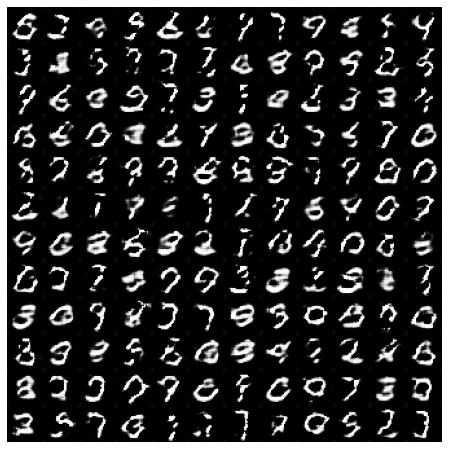

63.92095325190235
1


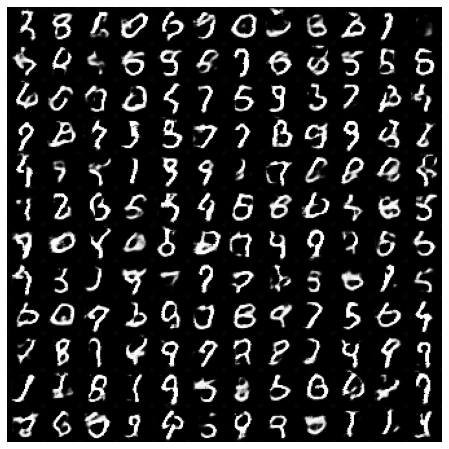

35.44302209316868
2


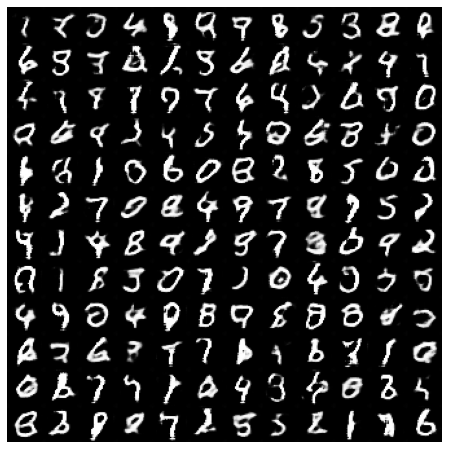

32.263007612513206
3


In [ ]:
if not skip_training:
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    learning_rate = 0.0001
    n_epochs = 21
    penalty = 10
    
    goptimizer = torch.optim.Adam(netG.parameters(), lr = learning_rate)
    doptimizer = torch.optim.Adam(netD.parameters(), lr = learning_rate)
    
    for epoch in range(n_epochs):
        
        print(epoch)
        
        for images, labels in trainloader:
            
            images = images.to(device)
            batch_size = images.size(0)
            
            
            goptimizer.zero_grad()
            doptimizer.zero_grad()
            
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fakes = netG(noise)
        
            d_loss1 = discriminator_loss(netD, images, fakes.detach())
            d_penalty, d_interpolates = gradient_penalty(netD, images, fakes.detach())
             
            d_loss = d_loss1 + penalty * d_penalty
                 
            d_loss.backward(retain_graph=True)
            doptimizer.step()
            
            #fakes2 = netG(noise)
            g_loss = generator_loss(netD, fakes)
                
            g_loss.backward()
            goptimizer.step()
                
        
        with torch.no_grad():
            # Plot generated images
            z = torch.randn(144, nz, 1, 1, device=device)
            samples = netG(z)
            tools.plot_generated_samples(samples)

            # Compute score
            z = torch.randn(1000, nz, 1, 1, device=device)
            samples = netG(z)
            score = fdscore.calculate(samples)
            print(score)
            
            if score < 8.0:
                tools.save_model(netG, '2_wgan_g.pth', confirm=False)
                tools.save_model(netD, '2_wgan_d.pth', confirm=False)
            if score < 7.0:
                break
            
    

In [20]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(netG, '2_wgan_g.pth', confirm=True)
    tools.save_model(netD, '2_wgan_d.pth', confirm=True)

In [21]:
if skip_training:
    nz = 10
    netG = Generator(nz=nz, ngf=128, nc=1)
    netD = Discriminator(nc=1, ndf=128)
    
    tools.load_model(netG, '2_wgan_g.pth', device)
    tools.load_model(netD, '2_wgan_d.pth', device)

Model loaded from 2_wgan_g.pth.
Model loaded from 2_wgan_d.pth.


## GAN evaluation

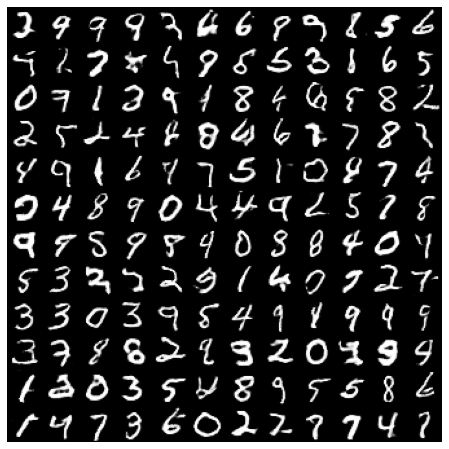

In [22]:
# Save generated samples (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    with torch.no_grad():
        z = torch.randn(144, nz, 1, 1, device=device)
        samples = netG(z)
        torch.save(samples, '2_wgan_samples.pth')
else:
    samples = torch.load('2_wgan_samples.pth', map_location=lambda storage, loc: storage)

tools.plot_generated_samples(samples)

In [23]:
# Compute the FD score
with torch.no_grad():
    z = torch.randn(1000, nz, 1, 1, device=device)
    samples = netG(z)
    score = fdscore.calculate(samples)

print(f'FD score: {score:.5f}')
assert score <= 10, "Too high FD score."
print('Success')

FD score: 6.34920
Success


In [25]:
samplesX = torch.load('2_wgan_samples.pth', map_location=lambda storage, loc: storage)
score = fdscore.calculate(samplesX)
print(score)

17.793577708128964


<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this notebook, we learned how to train Wasserstein GAN with gradient penalty.